In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import os
import json
from datetime import datetime

import numpy as np
import rasterio
import matplotlib.pyplot as plt

from torchgeo.datasets import BeninSmallHolderCashews

In [2]:
ROOT_DIR = os.path.expanduser("~/mount/data/")
API_KEY = ""

## Benchmarking

In [3]:
dataset = BeninSmallHolderCashews(
    root=ROOT_DIR,
    download=True,
    api_key=API_KEY,
    checksum=True,
    verbose=True
)

Files already downloaded and verified


In [4]:
%%time
# First hit on the dataset takes ~10 seconds when loading all bands
chip = dataset[0]

Loading all imagery
Loading imagery at 2019_11_05
Loading imagery at 2019_11_10
Loading imagery at 2019_11_15
Loading imagery at 2019_11_20
Loading imagery at 2019_11_30
Loading imagery at 2019_12_05
Loading imagery at 2019_12_10
Loading imagery at 2019_12_15
Loading imagery at 2019_12_20
Loading imagery at 2019_12_25
Loading imagery at 2019_12_30
Loading imagery at 2020_01_04
Loading imagery at 2020_01_09
Loading imagery at 2020_01_14
Loading imagery at 2020_01_19
Loading imagery at 2020_01_24
Loading imagery at 2020_01_29
Loading imagery at 2020_02_08
Loading imagery at 2020_02_13
Loading imagery at 2020_02_18
Loading imagery at 2020_02_23
Loading imagery at 2020_02_28
Loading imagery at 2020_03_04
Loading imagery at 2020_03_09
Loading imagery at 2020_03_14
Loading imagery at 2020_03_19
Loading imagery at 2020_03_24
Loading imagery at 2020_03_29
Loading imagery at 2020_04_03
Loading imagery at 2020_04_08
Loading imagery at 2020_04_13
Loading imagery at 2020_04_18
Loading imagery at 2

## Get dataset information

### Sorted dates

In [5]:
scenes = [] # list of tuples (datetime, directory name)
for fn in os.listdir(os.path.join(ROOT_DIR, "ts_cashew_benin/ts_cashew_benin_source/")):
    if os.path.isdir(os.path.join(ROOT_DIR, "ts_cashew_benin/ts_cashew_benin_source/", fn)):
        year, month, day = fn.split("_")[-3:] # in the format "ts_cashew_benin_source_00_{YEAR}_{MONTH}_{DAY}"
        date = datetime(year=int(year), month=int(month), day=int(day))
        scenes.append((date, f"{year}_{month}_{day}"))
scenes = sorted(scenes) # sort by datetimes
dates = list(zip(*scenes))[1] # unzip and keep only the directory names

In [6]:
len(dates)

70

### Class name to index mapping

In [7]:
with open(os.path.join(ROOT_DIR, "ts_cashew_benin/ts_cashew_benin_labels/_common/labels.geojson")) as f:
    geojson = json.load(f)
    
class_labels = set()
for feature in geojson["features"]:
    class_labels.add((feature["properties"]["class_name"], feature["properties"]["class"]))
    
class_labels

{('Background', 5),
 ('Non-planatation', 3),
 ('Poorly-managed planatation', 2),
 ('Residential', 4),
 ('Uncertain', 6),
 ('Well-managed planatation', 1)}

### Tile transform

In [8]:
# Checking to make sure that all files have the same transform

transform = None
for root, dirs, files in os.walk(os.path.join(ROOT_DIR, "ts_cashew_benin/ts_cashew_benin_source/"), topdown=False):
    for fn in files:
        if fn.endswith(".tif"):
            with rasterio.open(os.path.join(root, fn)) as f:
                if transform is None:
                    transform = f.transform
                else:
                    assert f.transform == transform
transform.a, transform.b, transform.c, transform.d, transform.e, transform.f

(10.002549584378608,
 0.0,
 440853.29890114715,
 0.0,
 -9.99842989423825,
 1012804.082877621)

## Visualizations

In [9]:
chip_size = 256
stride = 256

dataset = BeninSmallHolderCashews(
    ROOT_DIR,
    chip_size=chip_size,
    stride=stride,
    bands=("B04","B03","B02","CLD"),
    download=True, api_key=API_KEY,
    verbose=False
)

Files already downloaded and verified


In [10]:
CLOUD_MAX_PERCENT = 10
chip_idx = 8

# The third index is the "CLD" band which gives the per pixel probability of being cloudy
number_of_non_cloudy_pixels_by_date = (dataset[chip_idx]["image"][:,3] < CLOUD_MAX_PERCENT).sum(axis=(1,2))

# We only want to look at dates where _all_ the pixels in the chip are non cloudy
idxs = np.where(number_of_non_cloudy_pixels_by_date == chip_size*chip_size)[0]

chips = dataset[chip_idx]["image"][idxs,:3,:,:] # select the RGB bands from the non-cloudy dates
mask = dataset[chip_idx]["mask"] # the mask will be the same for all dates

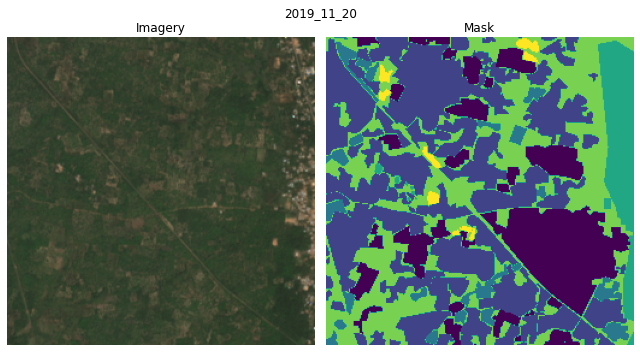

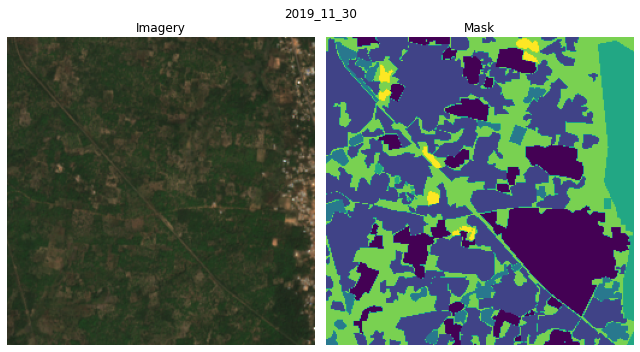

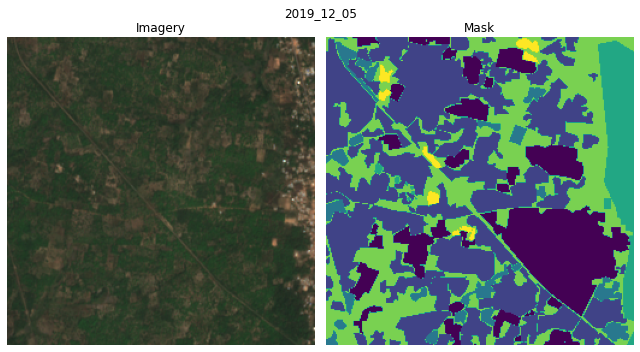

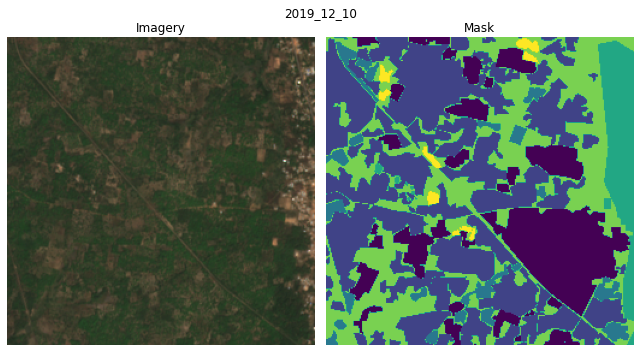

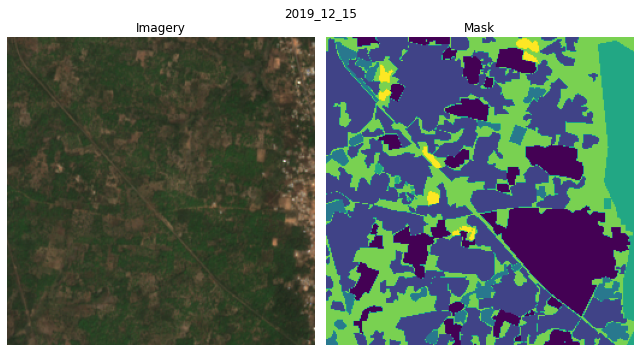

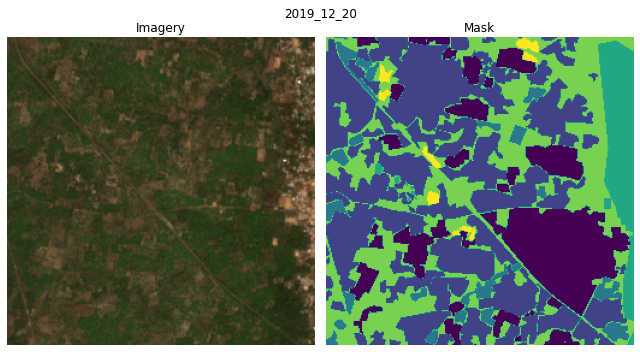

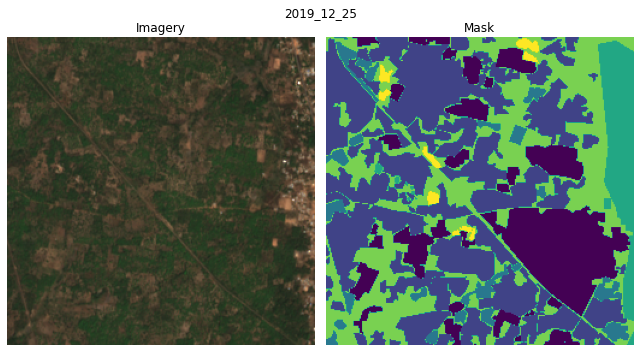

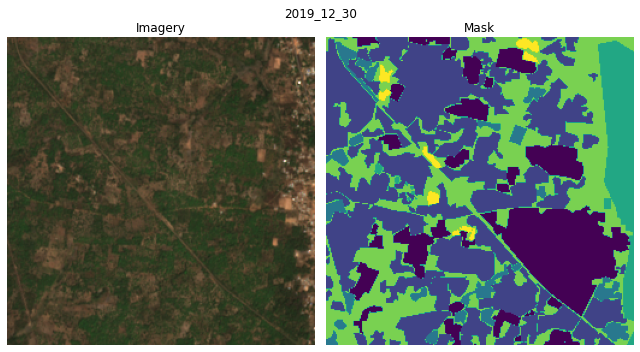

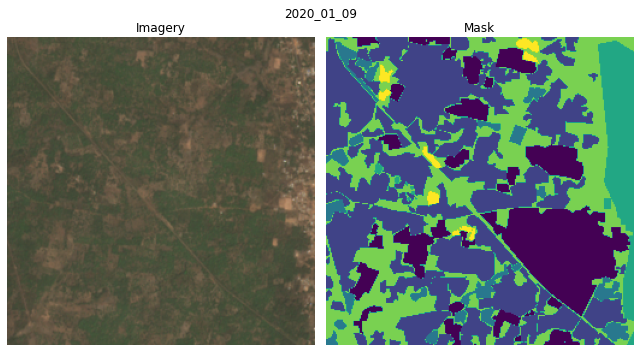

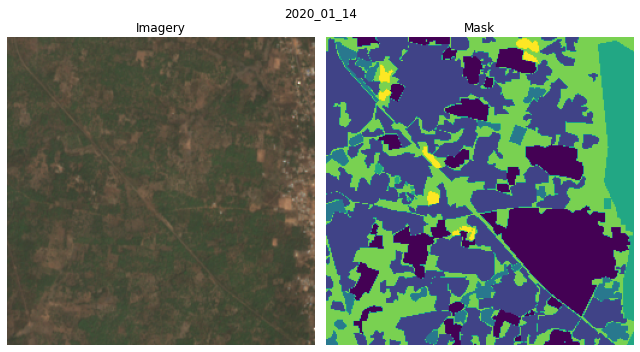

In [11]:
for chip, idx in list(zip(chips, idxs))[:10]:
    
    img = np.rollaxis(chip.numpy().copy(), 0, 3)
    img = np.clip(img / 3000, 0, 1) # we divide by 3000 and clip to get the RGB values into something we can look at

    fig, axs = plt.subplots(1,2,figsize=(9,5))
    axs[0].imshow(img)
    axs[0].axis("off")
    axs[0].set_title("Imagery")
    
    axs[1].imshow(mask)
    axs[1].axis("off")
    axs[1].set_title("Mask")
    
    plt.suptitle(dataset.dates[idx])
    plt.tight_layout()
    plt.show()
    plt.close()   